In [1]:
#!unzip intel.zip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
from pathlib import Path

In [3]:
train_dir = 'intel/seg_train/seg_train/'
test_dir = 'intel/seg_test/seg_test/'
pred_dir = 'intel/seg_pred/seg_pred/'

image_train = len(list(Path(train_dir).glob('*/*.jpg')))
image_test = len(list(Path(test_dir).glob('*/*.jpg')))
image_pred = len(list(Path(pred_dir).glob('*.jpg')))

print("Train images: ", image_train)
print("Test images: ", image_test)
print("Pred images: ", image_pred)

Train images:  14034
Test images:  3000
Pred images:  7301


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,                                            
                                                 seed=10, 
                                                 image_size = IMG_SIZE,
                                                 batch_size = BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                 seed=10, 
                                                 image_size = IMG_SIZE,
                                                 batch_size = BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


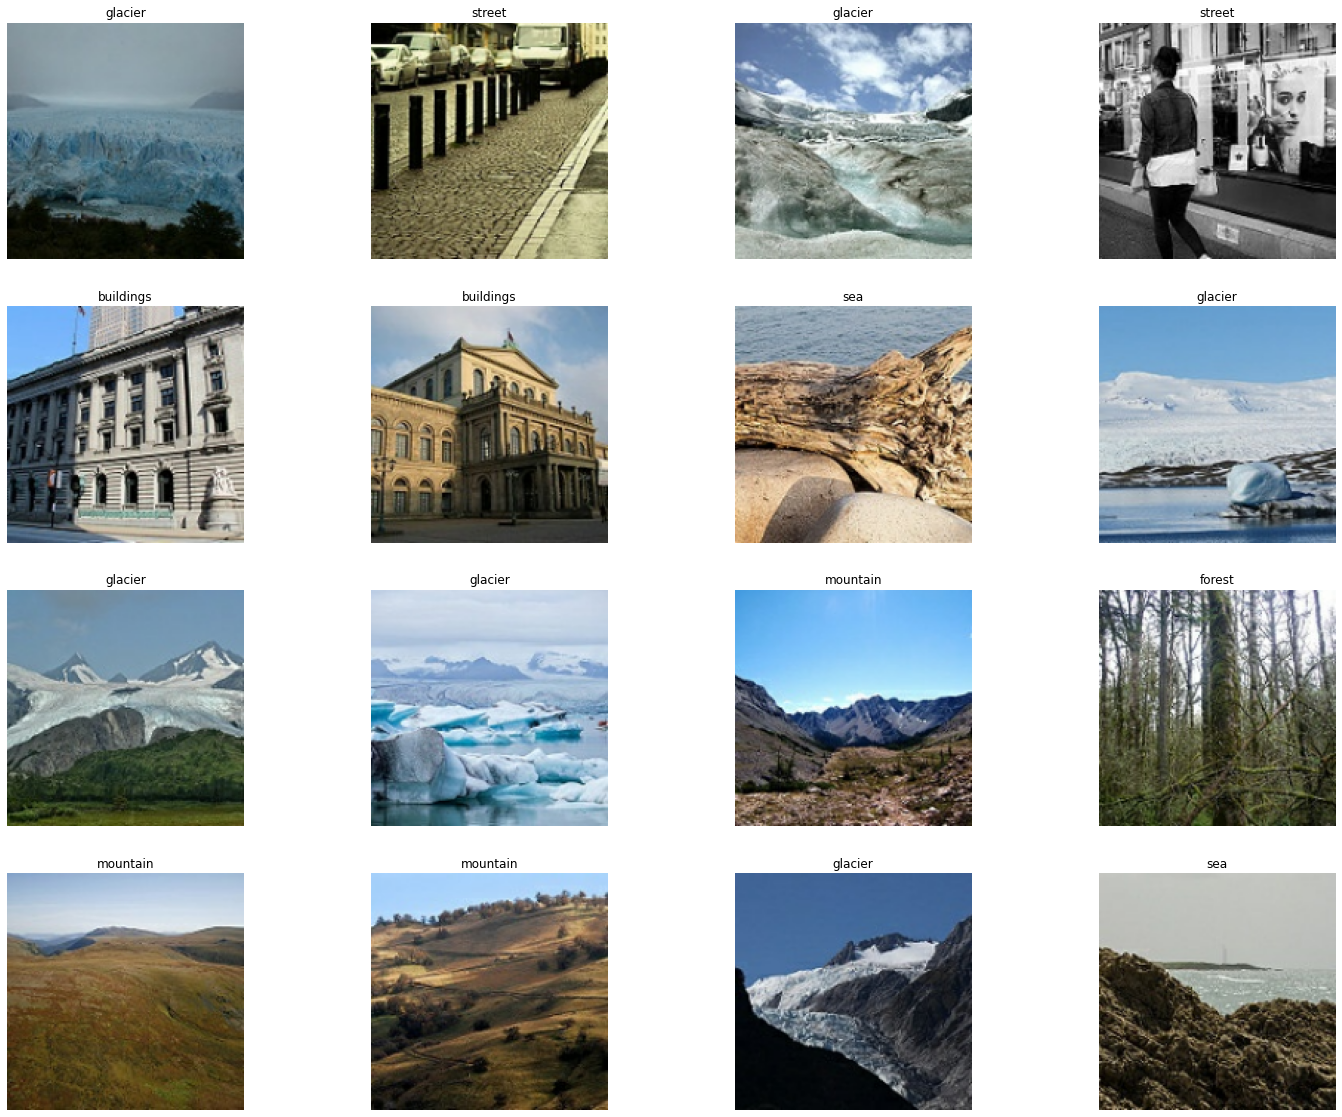

In [6]:
plt.figure(figsize=(25, 20))

for img, label in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal", input_shape=(150, 150,3)),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )

data_augmentation = data_augmenter()

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## MobileNetV2 Architecture

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights = 'imagenet')

base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 20, 20, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
          

                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malizatio

 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_

 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_

### Layer freezing with the Functional API

In [11]:
def model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')
    base_model.trainable = False
    
    # Architecture of top layer based on our use case
    inputs = tf.keras.Input(shape = input_shape)
    #x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training = False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    prediction_layer = tfl.Dense(6)
    outputs = prediction_layer(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [12]:
model = model(image_shape=IMG_SIZE, data_augmentation=data_augmenter())

In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=5000,
    decay_rate=0.95,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [14]:
model.compile(optimizer=optimizer, loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [15]:
history = model.fit(train_ds, 
                    validation_data = val_ds,
                    epochs = 100,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    verbose = 1)

Epoch 1/100
439/439 [==============================] - 150s 322ms/step - loss: 0.3757 - accuracy: 0.8609 - val_loss: 0.2439 - val_accuracy: 0.9100
Epoch 2/100
439/439 [==============================] - 141s 321ms/step - loss: 0.2394 - accuracy: 0.9119 - val_loss: 0.2336 - val_accuracy: 0.9177
Epoch 3/100
439/439 [==============================] - 137s 312ms/step - loss: 0.2160 - accuracy: 0.9185 - val_loss: 0.2240 - val_accuracy: 0.9177
Epoch 4/100
439/439 [==============================] - 136s 311ms/step - loss: 0.2027 - accuracy: 0.9245 - val_loss: 0.2217 - val_accuracy: 0.9200
Epoch 5/100
439/439 [==============================] - 136s 311ms/step - loss: 0.1909 - accuracy: 0.9280 - val_loss: 0.2370 - val_accuracy: 0.9183
Epoch 6/100
439/439 [==============================] - 136s 311ms/step - loss: 0.1816 - accuracy: 0.9339 - val_loss: 0.2405 - val_accuracy: 0.9097
Epoch 7/100
439/439 [==============================] - 136s 311ms/step - loss: 0.1784 - accuracy: 0.9324 - val_loss: 0

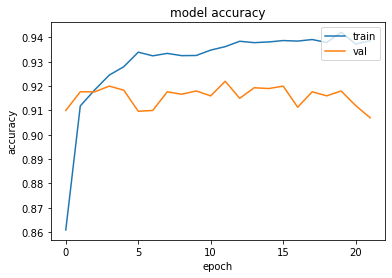

In [16]:
# Plot model accuracy 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

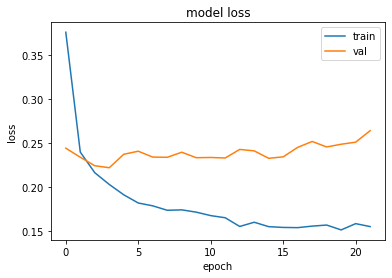

In [17]:
# Plot model loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [18]:
test_loss, val_acc = model.evaluate(val_ds, verbose=1)

print('\nTest accuracy: {:.3f}'.format(val_acc))

94/94 [==============================] - 24s 255ms/step - loss: 0.2638 - accuracy: 0.9070

Test accuracy: 0.907


In [19]:
from keras.utils import img_to_array, load_img
pred_dir = 'intel/seg_pred/seg_pred/'
# load all images into a list

images = []

for img in os.listdir(pred_dir):
    img = os.path.join(pred_dir, img) 
    img = load_img(img, target_size=(160, 160))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    images.append(img_array)

# stack up images list to pass for prediction
images = np.vstack(images)
predict = model.predict(images)
score = tf.nn.softmax([predict[0]])
classes = np.argmax(predict, axis=1)

229/229 [==============================] - 59s 255ms/step


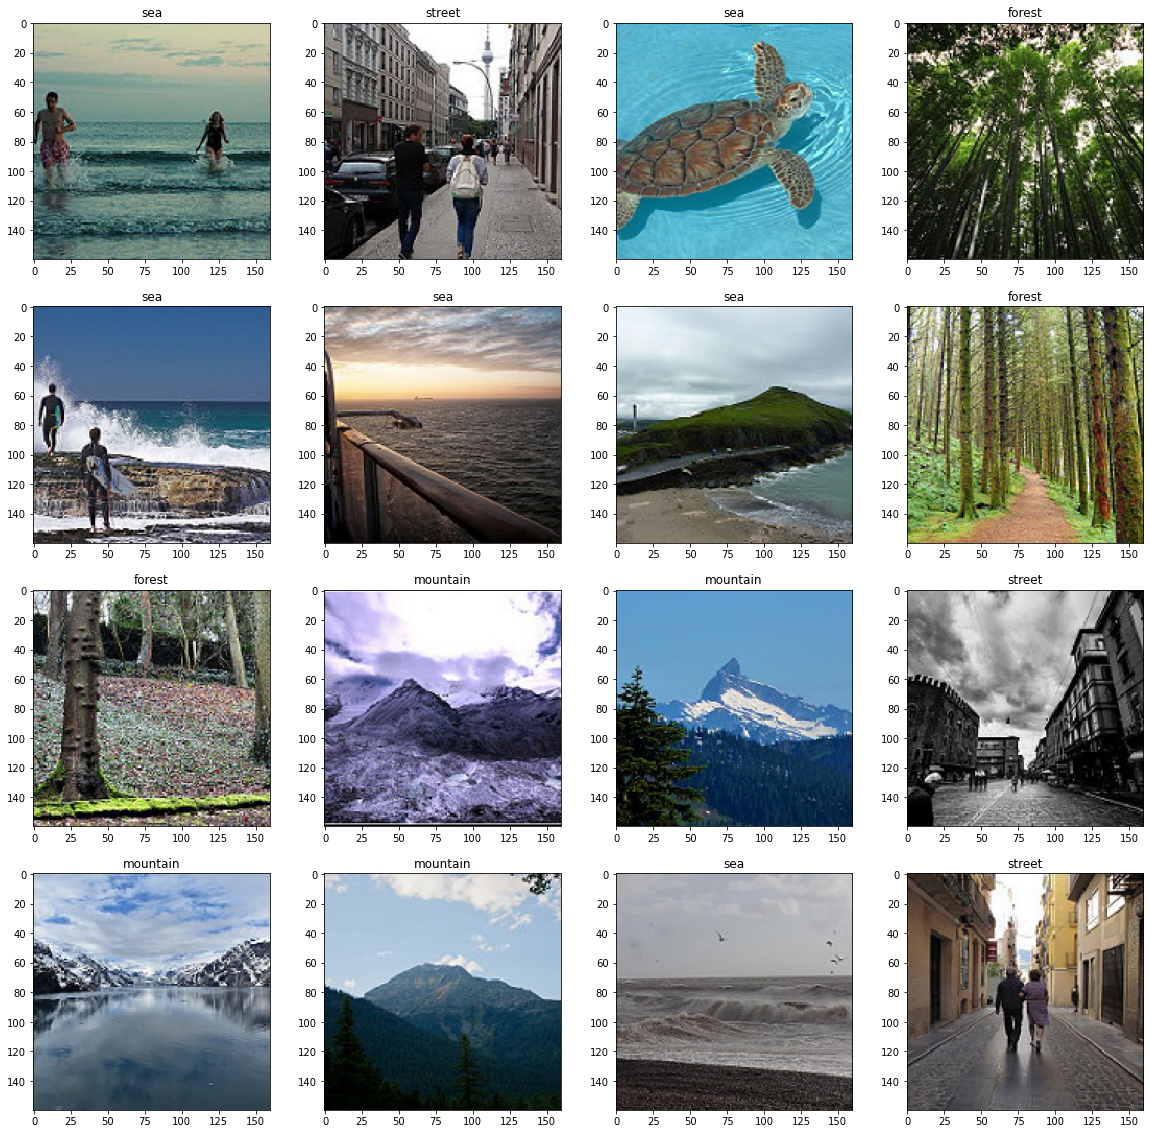

In [20]:
# Plot images 
plt.figure(figsize=(20, 20))

for i in range(16):
    rand = np.random.randint(0,len(images))
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[rand]/255)
    plt.title(class_names[classes[rand]])